# RL7 - Goal Based Policy

In this notebook, we are going to see what is goal based reinforcement learning, how Hindsight experience replay can solve the sparce reward problem in this context, and finaly we will try to use it to gather good rewards in swing up environment.


 1. [Goal Based Reinforcement Learning](#gbrl)
     1. [Problem statement](#gbrl_problem)
     2. [Goal based grid-world environment](#gbrl_grid_world)
     3. [Goal Conditioned DQN](#gbrl_dqn)
 2. [Sparce reward problem](#sparse)
     1. [Problem statement](#sparse_problem)
     2. [Hindsight Experience Replay (HER)](#her)
 3. [Swing Up]()
 


## Goal Based Reinforcement Learning
<div id="gbrl"></div>

### Problem statement
<div id="gbrl_problem"></div>

In reinforcement learning, an agent learn to maximise it's expected reward sum in an environment, by trials and errors. To learn, he will interact with it's environment, doing actions and reciving states and rewards in return. A serie of interactions is called an episode.

In goal based reinforcement learning, the agent will interact with it's environment the same way, except that the reward function will depend on a goal, given by the environment.

In general, the reward is constant while the agent don't find the goal, and is more important when he find it. If we want our agent to learn the shortest path to a goal, we can give him a reward of -1 at each step, and then a reward of 0 when he find it. Otherwise, we can simply give him a reward of 0, and a reward of 1 if he reach the goal. For this notebook, we will take the latest example in consideration.

#### Out of this course
Sometime, but we will not go deeper into it in this notebook, goal based reinforcement learning can be used while no  goals are given by the environment. The agent can choose (by [goal generation](https://arxiv.org/pdf/1807.04742.pdf) or by [goal selection among states inside the buffer](https://arxiv.org/pdf/1906.05253.pdf)) goals, that are suposed to help him explore or [that are promising to find rewards](https://arxiv.org/pdf/2106.03853.pdf), and try to reach them.


### Goal based grid-world environment
<div id="gbrl_grid_world"></div>

In order to go to the code step by step, we will consider the simplest goal reaching problem: the goal conditioned grid world environment.

Here, the agent is inside a grid of states, and try to reach another tile of the grid given by the environment.
States represent agent coordinates inside the grid, and availables actions are four simple mouvements TOP, RIGHT, DOWN and LEFT. In the grid, there is walls that make the environment more complex.

/home/ubuntu/anaconda3/envs/pie-rl/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


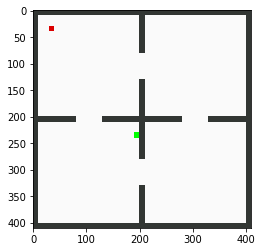

array([[[50, 54, 51],
        [50, 54, 51],
        [50, 54, 51],
        ...,
        [50, 54, 51],
        [50, 54, 51],
        [50, 54, 51]],

       [[50, 54, 51],
        [50, 54, 51],
        [50, 54, 51],
        ...,
        [50, 54, 51],
        [50, 54, 51],
        [50, 54, 51]],

       [[50, 54, 51],
        [50, 54, 51],
        [50, 54, 51],
        ...,
        [50, 54, 51],
        [50, 54, 51],
        [50, 54, 51]],

       ...,

       [[50, 54, 51],
        [50, 54, 51],
        [50, 54, 51],
        ...,
        [50, 54, 51],
        [50, 54, 51],
        [50, 54, 51]],

       [[50, 54, 51],
        [50, 54, 51],
        [50, 54, 51],
        ...,
        [50, 54, 51],
        [50, 54, 51],
        [50, 54, 51]],

       [[50, 54, 51],
        [50, 54, 51],
        [50, 54, 51],
        ...,
        [50, 54, 51],
        [50, 54, 51],
        [50, 54, 51]]], dtype=uint8)

In [1]:
import gym
import environments.grid_world


environment = gym.make("goal_conditioned_discrete_grid_world-v0")
environment.reset()
environment.render()

### Goal Conditioned DQN
<div id="gbrl_dqn"></div>

Because the action space is discrete, we will use a DQN (the state space is also discrete but neural network will archive better performances than tabular Q-learning).

Here is a "simple" implementation of goal conditioned default agent (this new agent looks like our last global agent class from RL6 notebook, so I put a # NEW tag when there is something new.). 

In [2]:
import torch


DEFAULT_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class GoalConditionedAgent:
    """
    An global agent class for goal conditioned agents. The # NEW tag indicate differences between Agent class and this
    one.
    """

    def __init__(self, state_space, action_space, goal_size=None, device=DEFAULT_DEVICE, name="Random agent"):
        self.name = name  # The name is used inside plot legend, outputs directory path, and outputs file names

        self.state_space = state_space
        self.state_shape = state_space.shape
        self.state_size = state_space.shape[0]  # Assume state space is continuous
        self.goal_size = self.state_size if goal_size is None else goal_size
        self.continuous = isinstance(action_space, gym.spaces.Box)
        self.action_space = action_space
        self.nb_actions = self.action_space.shape[0] if self.continuous else self.action_space.n
        self.last_state = None
        self.device = device
        self.episode_id = 0
        self.episode_time_step_id = 0
        self.time_step_id = 0

        # New
        # The goal we are trying to reach will be set when a new episode is started.
        # We need to keep it in memory during the entire episode
        self.current_goal = None

    def on_simulation_start(self):
        """
        Called when an episode is started. will be used by child class.
        """
        pass

    def on_episode_start(self, state, goal): # <-
        # because the signature of this function changed, 
        # this class cannot heritate from Agent base class :(.
        self.last_state = state
        self.episode_time_step_id = 0
        self.episode_id = 0
        self.current_goal = goal  # NEW

    def action(self, state):
        res = self.action_space.sample()
        return res

    def on_action_stop(self, action, new_state, reward, done):
        self.episode_time_step_id += 1
        self.time_step_id += 1
        self.last_state = new_state

    def on_episode_stop(self):
        self.episode_id += 1

    def on_simulation_stop(self):
        pass



Now we want to convert the DQN adgent we had in RL6 notebook into a goal-conditionned agent.
Bellow, you will find this exact same class, with # TODO tags where you should modify something to handle the given goal, and make our DQN agent be conditioned by a goal.

<div class="alert alert-warning">
At each episode, we will receive a new goal. How can we make a DQN agent (that use a Q-network and choose actions using argmax(Q(s, a))) choose actions depending on the goal ?
<div/>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>
    In RL6 notebook we modified our Q-Network ton convert him into a critic, so he can return a value from a state and an action. Here, we are going to do something similar, and append the goal to the state before giving it the the Q-network.
    
For your curiosity, we can do that kind of "intrinsic state" for many usage, like for example make our agent learn different behaviours as skills. We can have for example five skills, and concatenate a skill id to the state to make our agent have different behaviours, depending on the skill we give to him (like in [DIAYN](https://sites.google.com/view/diayn/) algorithm). But it's not the subject of this notebook, maybe of another one :).
    
For the critic, we will do the exact same thing. Because the Q-value of a state action pair will depends on the goal, the input of the critic will look like this: (state, goal, action)

<details/>

Now you can modify the DQN class below.

HINT: For now, we will assume that the goal is another state in the environment. So it's size is 'self.state_size'.

To help you find them faster:
 - TODO: Change __init__ function to handle goal inside agent parameters initialisation,
 - TODO: Change the action function so the action can be conditioned by BOTH state and goal,
 - TODO: Change the on_action_stop function so the goal can be also stored by the agent,
 - TODO: Change the learn function so the q-values can be conditioned by BOTH state and goal.

In [10]:
# First, let's modify our last replay buffer to make it able to store goals
import random


class ReplayBuffer:
    def __init__(self, capacity, device=DEFAULT_DEVICE):
        self.capacity = capacity # capacity of the buffer
        self.device = device
        self.data = []
        self.index = 0 # index of the next cell to be filled

    def append(self, s, a, r, s_, d, g):  # NEW added goal
        if len(self.data) < self.capacity:
            self.data.append(None)
        self.data[self.index] = (s, a, r, s_, d, g)  # NEW added goal
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.data, batch_size)
        return list(map(lambda x:torch.Tensor(x).to(self.device), list(zip(*batch))))

    def __len__(self):
        return len(self.data)

# I also give the converge_to function if you want to use it, but it's not necessarily needed.
def converge_to(self, model, other_model, tau=0.01):
    for self_param, other_param in zip(model.parameters(), other_model.parameters()):
        self_param.data.copy_(
            self_param.data * (1.0 - tau) + other_param.data * tau
        )

In [11]:
import copy

import gym
import numpy as np
import torch
from torch import nn
from agents.nn.multilayers_perceptron import MLP
from agents.agent import Agent


class GCDQNAgent(GoalConditionedAgent):  # NEW, our DQN agent heritate from GoalConditionedAgent.
    """
    GCDQN for Goal Conditioned Deep Q-Network
    An agent that learn to reach goals using DQN.
    This Q-Function is used to find the best action to execute in a given state.
    """

    def __init__(self, state_space, action_space, goal_size=None, name="DQN",
                 gamma=0.95, epsilon_min=0.01, epsilon_max=1., epsilon_decay_period=1000, epsilon_decay_delay=20,
                 buffer_size=1000000, learning_rate=0.001, update_target_freq=100, batch_size=20,
                 layer_1_size=50, layer_2_size=50, nb_gradient_steps=1):

        assert isinstance(action_space, gym.spaces.Discrete)  # Make sure our action space is discrete
        super().__init__(state_space, action_space, goal_size=goal_size, name=name)

        self.gamma = gamma
        self.epsilon_min = epsilon_min
        self.epsilon_max = epsilon_max
        self.epsilon_decay_delay = epsilon_decay_delay
        self.epsilon = None
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.update_target_freq = update_target_freq
        self.nb_gradient_steps = nb_gradient_steps

        self.epsilon_step = (epsilon_max - self.epsilon_min) / epsilon_decay_period

        # TODO: Change __init__ function to handle goal inside agent parameters initialisation
        # (Spoiler: There is nothing to change above)
        self.replay_buffer = ReplayBuffer(buffer_size)
        self.total_steps = 0
        self.model = MLP(self.state_size*2, layer_1_size, layer_2_size, self.nb_actions, 
                         learning_rate=self.learning_rate, device=self.device)

        self.criterion = torch.nn.SmoothL1Loss()
        self.target_model = copy.deepcopy(self.model).to(self.device)
        self.update_target_freq = update_target_freq
    
    def on_episode_start(self, state, goal):
        # New, call to super class, it will store the goal so we can use it later.
        super().on_episode_start(state, goal)

    def on_simulation_start(self):
        self.epsilon = self.epsilon_max

    def action(self, state, goal):
        if self.time_step_id > self.epsilon_decay_delay:
            self.epsilon = max(self.epsilon_min, self.epsilon - self.epsilon_step)

        if np.random.rand() < self.epsilon:  # Epsilon greedy
            action = np.random.randint(self.nb_actions)
        else:
            # greedy_action(self.model, state) function in RL5 notebook
            with torch.no_grad():
                Q = self.model(torch.Tensor(state, goal).unsqueeze(0).to(self.device))
                action = torch.argmax(Q).item()
        return action

    def on_action_stop(self, action, new_state, reward, done):
        self.replay_buffer.append(self.last_state, action, reward, new_state, done, goal)
        self.learn()
        super().on_action_stop(action, new_state, reward, done, goal)  # Replace self.last_state by the new_state

    def learn(self):
        for _ in range(self.nb_gradient_steps):
            # gradient_step() function in RL5 notebook
            if len(self.replay_buffer) > self.batch_size:
                states, actions, rewards, new_states, dones, goals = self.replay_buffer.sample(self.batch_size)
                q_prime = self.target_model(new_states, goals).max(1)[0].detach()
                update = torch.addcmul(rewards, self.gamma, 1 - dones, q_prime)
                q_s_a = self.model(states, goals).gather(1, actions.to(torch.long).unsqueeze(1))
                loss = self.criterion(q_s_a, update.unsqueeze(1))
                self.model.learn(loss)

        # update target network if needed
        if self.time_step_id % self.update_target_freq == 0:
            self.target_model.load_state_dict(self.model.state_dict())

In [12]:
# %load solutions/RL7/goal_conditioned_dqn.py
import copy

import gym
import numpy as np
import torch
from torch import nn, optim
from torch.nn import ReLU

from agents.nn.multilayers_perceptron import MLP


class GCDQNAgent(GoalConditionedAgent):
    """
    An agent that learn an approximated Q-Function using a neural network.
    This Q-Function is used to find the best action to execute in a given state.
    """

    def __init__(self, state_space, action_space, goal_size=None, name="DQN",
                 gamma=0.95, epsilon_min=0.01, epsilon_max=1., epsilon_decay_period=1000, epsilon_decay_delay=20,
                 buffer_size=1000000, learning_rate=0.001, update_target_freq=100, batch_size=125,
                 layer_1_size=250, layer_2_size=200, nb_gradient_steps=1):

        assert isinstance(action_space, gym.spaces.Discrete)  # Make sure our action space is discrete
        super().__init__(state_space, action_space, goal_size=goal_size, name=name)

        self.gamma = gamma
        self.epsilon_min = epsilon_min
        self.epsilon_max = epsilon_max
        self.epsilon_decay_delay = epsilon_decay_delay
        self.epsilon = None

        #  NEW, goals will be stored inside the replay buffer. We need a specific one with enough place to do so
        self.replay_buffer = ReplayBuffer(buffer_size)
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.update_target_freq = update_target_freq
        self.nb_gradient_steps = nb_gradient_steps

        self.epsilon_step = (epsilon_max - self.epsilon_min) / epsilon_decay_period
        self.total_steps = 0

        # NEW, The input state size is multiplied by two because we need to also take the goal as input
        self.model = MLP(self.state_size + self.goal_size, layer_1_size, ReLU(), layer_2_size, ReLU(), 
                         self.nb_actions, learning_rate=learning_rate, optimizer_class=optim.Adam, 
                         device=self.device).float()

        self.criterion = torch.nn.SmoothL1Loss()
        self.target_model = copy.deepcopy(self.model).to(self.device)
        self.update_target_freq = update_target_freq

    def on_simulation_start(self):
        self.epsilon = self.epsilon_max

    def action(self, state):
        if self.time_step_id > self.epsilon_decay_delay:
            self.epsilon = max(self.epsilon_min, self.epsilon - self.epsilon_step)

        if np.random.rand() < self.epsilon:  # Epsilon greedy
            action = np.random.randint(self.nb_actions)
        else:
            # greedy_action(self.model, state) function in RL5 notebook
            with torch.no_grad():
                goal_conditioned_state = np.concatenate((state, self.current_goal), axis=-1)
                Q = self.model(goal_conditioned_state)
                action = torch.argmax(Q).item()
        return action

    def on_action_stop(self, action, new_state, reward, done):
        # NEW store the current goal, so it can be associated with samples
        self.replay_buffer.append(self.last_state, action, reward, new_state, done, self.current_goal)
        self.learn()
        super().on_action_stop(action, new_state, reward, done)  # Replace self.last_state by the new_state

    def learn(self):
        for _ in range(self.nb_gradient_steps):
            # gradient_step() function in RL5 notebook
            if len(self.replay_buffer) > self.batch_size:
                #  NEW, samples from buffer contains goals
                states, actions, rewards, new_states, dones, goals = self.replay_buffer.sample(self.batch_size)

                # NEW concatenate states and goals, because we need to put them inside our model
                goal_conditioned_states = torch.concat((states, goals), dim=-1)
                goal_conditioned_new_states = torch.concat((new_states, goals), dim=-1)

                q_prime = self.target_model(goal_conditioned_new_states).max(1)[0].detach()
                update = rewards + self.gamma * (1 - dones) * q_prime
                q_s_a = self.model(goal_conditioned_states).gather(1, actions.to(torch.long).unsqueeze(1))
                loss = self.criterion(q_s_a, update.unsqueeze(1))
                self.model.learn(loss)

        # update target network if needed
        if self.time_step_id % self.update_target_freq == 0:
            self.target_model.load_state_dict(self.model.state_dict())



Now, we can test our agent performences in the first map of the grid world environment.
First, let's reload the simulation function we had at RL6 notebook.

In [7]:
from statistics import mean


def simulation(environment, agent, nb_episodes=1000, verbose=True):
    episodes_rewards_sum = []
    test_results = []
    agent.on_simulation_start()
    for episode_id in range(nb_episodes):
        state, goal = environment.reset()
        agent.on_episode_start(state, goal)

        episode_rewards = []
        done = False
        while not done:
            action = agent.action(state)
            state, reward, done, _ = environment.step(action)

            # Ending time step process ...
            agent.on_action_stop(action, state, reward, done)

            # Store reward
            episode_rewards.append(reward)
        agent.on_episode_stop()
        rewards_sum = sum(episode_rewards)
        episodes_rewards_sum.append(rewards_sum)
        environment.close()
        if len(episodes_rewards_sum) > 20:
            last_20_average = mean(episodes_rewards_sum[-20:])
        else:
            last_20_average = mean(episodes_rewards_sum)

        if verbose:
            print("Episode " + str(episode_id) + ", episode return " + str(rewards_sum) + ", last 20 avg "
                  + str(last_20_average))
        
        if episode_id != 0 and episode_id % 10 == 0:
            render = False
            test_results.append(test(environment, agent, verbose=False, render=render))

    return episodes_rewards_sum, test_results  # We will plot tests results, not the sum of rewards

Now, we want a function to evaluate our agent performances. In a test function, we want to exploit what our agent learned, but we don't want him to learn. Sometime, testing process can give extrinsic information that are too hard for him to gather.

For example, in general, in goal gonditioned learning, we want our agent to generate his own goals (by taking
states from his buffer [https://arxiv.org/abs/1906.05253], or generate them using VAE
[https://arxiv.org/pdf/1807.04742.pdf]. But, by testing our agent, we will generate goals that are far from his
starting position to verify if he can reach them. Doing so, we will give his the information that these states
exist, and help him to explore.

To make sure the agent don't learn, we don't call the agent function that make him train (agent.on_action_stop).
Then, we want this function to return an average grade over every tests. This distance can be the average distance between the final state of the trajectory, and the goal.

In [8]:
from statistics import mean


def test(environment, agent, nb_tests=20, verbose=True, render=False):
    episodes_grades = []
    agent.on_simulation_start()
    average_grade = None
    for test_id in range(nb_tests):
        if isinstance(environment, GoalCartPoleSwingUp):
            state, goal = environment.reset(test=True)
        else:
            state, goal = environment.reset()
        agent.on_episode_start(state, goal)
        if render:
            plt.cla()
            image = environment.render()
            plt.imshow(image)
            plt.show()

        episode_rewards = []
        done = False
        while not done:
            action = agent.action(state)
            state, reward, done, _ = environment.step(action)
            if render:
                plt.imshow(environment.render())
                plt.show()

        # Compute distance to goal
        distance_to_goal = np.linalg.norm(state[-2:] - goal, 2)
        episodes_grades.append(- distance_to_goal)
        agent.on_episode_stop()
        environment.close()
        average_grade = mean(episodes_grades)
        if verbose:
            print("Test " + str(test_id) + ", - distance = " + str(- distance_to_goal) + ", avg "
                  + str(average_grade))
    return average_grade

Finally, with a simulation function and a test one, we can observe how our DQNAgent learn on a simple tiny single room map.

/home/ubuntu/anaconda3/envs/pie-rl/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


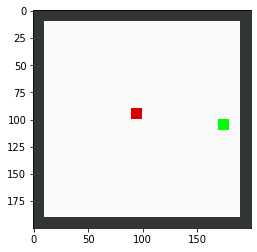


###################

      SEED 0

###################

 > Training DQN

Episode 0, episode return 1.0, last 20 avg 1.0
Episode 1, episode return 0.0, last 20 avg 0.5
Episode 2, episode return 1.0, last 20 avg 0.6666666666666666
Episode 3, episode return 0.0, last 20 avg 0.5
Episode 4, episode return 0.0, last 20 avg 0.4
Episode 5, episode return 0.0, last 20 avg 0.3333333333333333
Episode 6, episode return 0.0, last 20 avg 0.2857142857142857
Episode 7, episode return 0.0, last 20 avg 0.25
Episode 8, episode return 0.0, last 20 avg 0.2222222222222222
Episode 9, episode return 1.0, last 20 avg 0.3
Episode 10, episode return 0.0, last 20 avg 0.2727272727272727
Episode 11, episode return 0.0, last 20 avg 0.25
Episode 12, episode return 0.0, last 20 avg 0.23076923076923078
Episode 13, episode return 0.0, last 20 avg 0.21428571428571427
Episode 14, episode return 1.0, last 20 avg 0.26666666666666666
Episode 15, episode return 0.0, last 20 avg 0.25
Episode 16, episode return 0.0, last 20 av

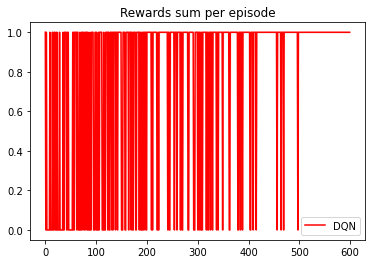

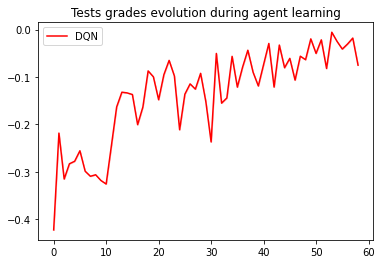


###################

      SEED 1

###################

 > Training DQN

Episode 0, episode return 0.0, last 20 avg 0.0
Episode 1, episode return 0.0, last 20 avg 0.0
Episode 2, episode return 0.0, last 20 avg 0.0
Episode 3, episode return 0.0, last 20 avg 0.0
Episode 4, episode return 0.0, last 20 avg 0.0
Episode 5, episode return 0.0, last 20 avg 0.0
Episode 6, episode return 0.0, last 20 avg 0.0
Episode 7, episode return 0.0, last 20 avg 0.0
Episode 8, episode return 0.0, last 20 avg 0.0
Episode 9, episode return 0.0, last 20 avg 0.0
Episode 10, episode return 0.0, last 20 avg 0.0
Episode 11, episode return 0.0, last 20 avg 0.0
Episode 12, episode return 0.0, last 20 avg 0.0
Episode 13, episode return 0.0, last 20 avg 0.0
Episode 14, episode return 0.0, last 20 avg 0.0
Episode 15, episode return 0.0, last 20 avg 0.0
Episode 16, episode return 0.0, last 20 avg 0.0
Episode 17, episode return 0.0, last 20 avg 0.0
Episode 18, episode return 0.0, last 20 avg 0.0
Episode 19, episode retu

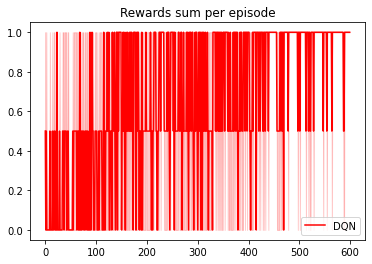

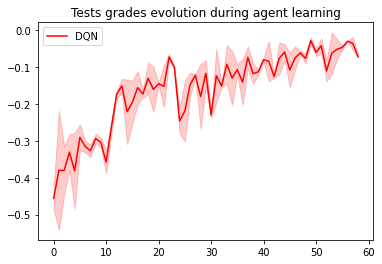


###################

      SEED 2

###################

 > Training DQN

Episode 0, episode return 0.0, last 20 avg 0.0
Episode 1, episode return 0.0, last 20 avg 0.0
Episode 2, episode return 0.0, last 20 avg 0.0
Episode 3, episode return 0.0, last 20 avg 0.0
Episode 4, episode return 0.0, last 20 avg 0.0
Episode 5, episode return 0.0, last 20 avg 0.0
Episode 6, episode return 0.0, last 20 avg 0.0
Episode 7, episode return 0.0, last 20 avg 0.0
Episode 8, episode return 0.0, last 20 avg 0.0
Episode 9, episode return 0.0, last 20 avg 0.0
Episode 10, episode return 0.0, last 20 avg 0.0
Episode 11, episode return 0.0, last 20 avg 0.0
Episode 12, episode return 0.0, last 20 avg 0.0
Episode 13, episode return 0.0, last 20 avg 0.0
Episode 14, episode return 0.0, last 20 avg 0.0
Episode 15, episode return 0.0, last 20 avg 0.0
Episode 16, episode return 0.0, last 20 avg 0.0
Episode 17, episode return 1.0, last 20 avg 0.05555555555555555
Episode 18, episode return 0.0, last 20 avg 0.0526315789

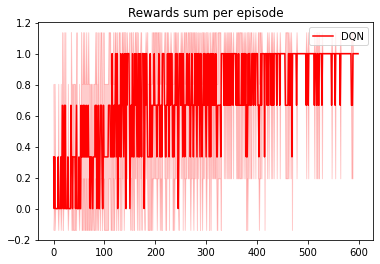

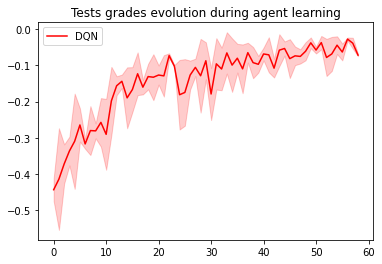


###################

      SEED 3

###################

 > Training DQN

Episode 0, episode return 0.0, last 20 avg 0.0
Episode 1, episode return 0.0, last 20 avg 0.0
Episode 2, episode return 0.0, last 20 avg 0.0
Episode 3, episode return 0.0, last 20 avg 0.0
Episode 4, episode return 0.0, last 20 avg 0.0
Episode 5, episode return 0.0, last 20 avg 0.0
Episode 6, episode return 0.0, last 20 avg 0.0
Episode 7, episode return 0.0, last 20 avg 0.0
Episode 8, episode return 0.0, last 20 avg 0.0
Episode 9, episode return 0.0, last 20 avg 0.0
Episode 10, episode return 0.0, last 20 avg 0.0
Episode 11, episode return 0.0, last 20 avg 0.0
Episode 12, episode return 0.0, last 20 avg 0.0
Episode 13, episode return 0.0, last 20 avg 0.0
Episode 14, episode return 0.0, last 20 avg 0.0
Episode 15, episode return 0.0, last 20 avg 0.0
Episode 16, episode return 0.0, last 20 avg 0.0
Episode 17, episode return 0.0, last 20 avg 0.0
Episode 18, episode return 0.0, last 20 avg 0.0
Episode 19, episode retu

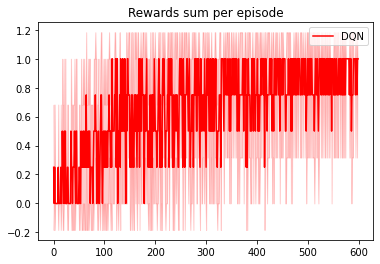

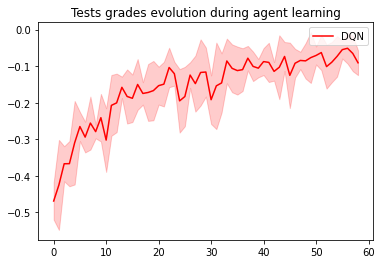

In [14]:
import matplotlib.pyplot as plt
from environments.swingup import GoalCartPoleSwingUp


environment = gym.make("goal_conditioned_discrete_grid_world-v0")
environment.__init__(map_id=1)
environment.render()

nb_seeds = 4
nb_episodes_per_simulations = 600

dqn_seeds_rewards_result = []
dqn_seeds_tests_result = []
colors = ["#ff0000", "#ff9500"]

for seed_id in range(nb_seeds):
    print()
    print("###################")
    print()
    print("      SEED " + str(seed_id))
    print()
    print("###################")

    print()
    print(" > Training DQN")
    print()
    dqn_agent = GCDQNAgent(environment.observation_space, environment.action_space)
    rewards_sum_per_episode, tests_results = simulation(environment, dqn_agent,
                                                        nb_episodes=nb_episodes_per_simulations)
    dqn_seeds_rewards_result.append(rewards_sum_per_episode)
    dqn_seeds_tests_result.append(tests_results)

    plt.cla()
    plt.title("Rewards sum per episode")
    dqn_means = np.mean(np.array(dqn_seeds_rewards_result), axis=0)
    dqn_stds = np.std(np.array(dqn_seeds_rewards_result), axis=0)
    plt.plot(dqn_means, color=colors[0], label="DQN")
    plt.fill_between([x for x in range(len(dqn_means))], dqn_means + dqn_stds, dqn_means - dqn_stds, color=colors[0],
                     alpha=0.2)
    plt.legend()
    plt.show()

    plt.cla()
    plt.title("Tests grades evolution during agent learning")
    dqn_means = np.mean(np.array(dqn_seeds_tests_result), axis=0)
    dqn_stds = np.std(np.array(dqn_seeds_tests_result), axis=0)
    plt.plot(dqn_means, color=colors[0], label="DQN")
    plt.fill_between([x for x in range(len(dqn_means))], dqn_means + dqn_stds, dqn_means - dqn_stds, color=colors[0],
                     alpha=0.2)
    plt.legend()
    plt.show()

At this step, you should have a goal conditioned DQN that learn well on a simple and tiny map. Let's try him on a more large and more complicated 4 rooms environment.

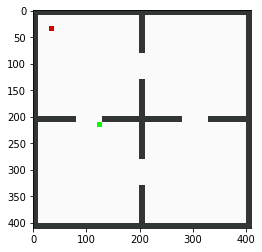


###################

      SEED 0

###################

 > Training DQN

Episode 0, episode return 0.0, last 20 avg 0.0
Episode 1, episode return 0.0, last 20 avg 0.0
Episode 2, episode return 0.0, last 20 avg 0.0
Episode 3, episode return 0.0, last 20 avg 0.0
Episode 4, episode return 0.0, last 20 avg 0.0
Episode 5, episode return 0.0, last 20 avg 0.0
Episode 6, episode return 0.0, last 20 avg 0.0
Episode 7, episode return 0.0, last 20 avg 0.0
Episode 8, episode return 0.0, last 20 avg 0.0
Episode 9, episode return 0.0, last 20 avg 0.0
Episode 10, episode return 0.0, last 20 avg 0.0
Episode 11, episode return 0.0, last 20 avg 0.0
Episode 12, episode return 0.0, last 20 avg 0.0
Episode 13, episode return 0.0, last 20 avg 0.0
Episode 14, episode return 0.0, last 20 avg 0.0
Episode 15, episode return 0.0, last 20 avg 0.0
Episode 16, episode return 0.0, last 20 avg 0.0
Episode 17, episode return 0.0, last 20 avg 0.0
Episode 18, episode return 0.0, last 20 avg 0.0
Episode 19, episode retu

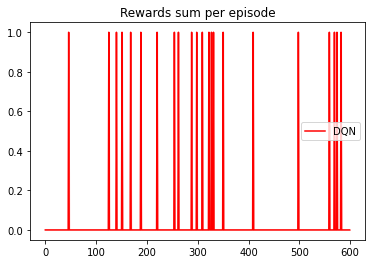

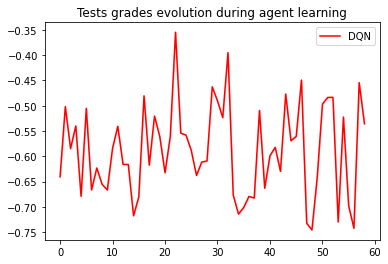


###################

      SEED 1

###################

 > Training DQN

Episode 0, episode return 0.0, last 20 avg 0.0
Episode 1, episode return 0.0, last 20 avg 0.0
Episode 2, episode return 0.0, last 20 avg 0.0
Episode 3, episode return 0.0, last 20 avg 0.0
Episode 4, episode return 0.0, last 20 avg 0.0
Episode 5, episode return 0.0, last 20 avg 0.0
Episode 6, episode return 0.0, last 20 avg 0.0
Episode 7, episode return 0.0, last 20 avg 0.0
Episode 8, episode return 0.0, last 20 avg 0.0
Episode 9, episode return 0.0, last 20 avg 0.0
Episode 10, episode return 0.0, last 20 avg 0.0
Episode 11, episode return 0.0, last 20 avg 0.0
Episode 12, episode return 0.0, last 20 avg 0.0
Episode 13, episode return 0.0, last 20 avg 0.0
Episode 14, episode return 0.0, last 20 avg 0.0
Episode 15, episode return 0.0, last 20 avg 0.0
Episode 16, episode return 0.0, last 20 avg 0.0
Episode 17, episode return 0.0, last 20 avg 0.0
Episode 18, episode return 0.0, last 20 avg 0.0
Episode 19, episode retu

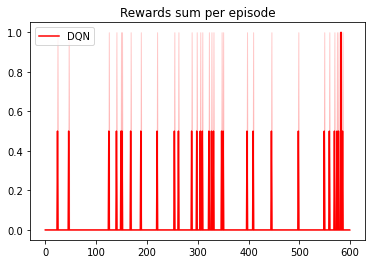

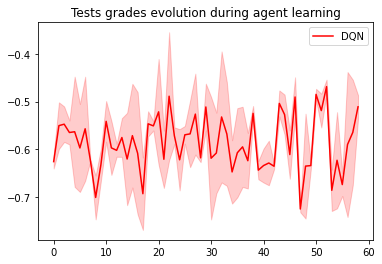


###################

      SEED 2

###################

 > Training DQN

Episode 0, episode return 0.0, last 20 avg 0.0
Episode 1, episode return 0.0, last 20 avg 0.0
Episode 2, episode return 0.0, last 20 avg 0.0
Episode 3, episode return 0.0, last 20 avg 0.0
Episode 4, episode return 0.0, last 20 avg 0.0
Episode 5, episode return 0.0, last 20 avg 0.0
Episode 6, episode return 0.0, last 20 avg 0.0
Episode 7, episode return 0.0, last 20 avg 0.0
Episode 8, episode return 0.0, last 20 avg 0.0
Episode 9, episode return 0.0, last 20 avg 0.0
Episode 10, episode return 0.0, last 20 avg 0.0
Episode 11, episode return 0.0, last 20 avg 0.0
Episode 12, episode return 0.0, last 20 avg 0.0
Episode 13, episode return 0.0, last 20 avg 0.0
Episode 14, episode return 0.0, last 20 avg 0.0
Episode 15, episode return 0.0, last 20 avg 0.0
Episode 16, episode return 0.0, last 20 avg 0.0
Episode 17, episode return 0.0, last 20 avg 0.0
Episode 18, episode return 0.0, last 20 avg 0.0
Episode 19, episode retu

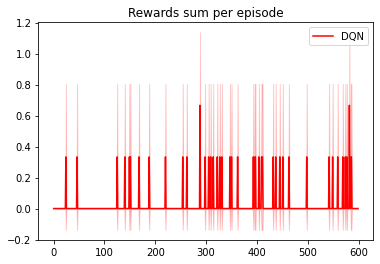

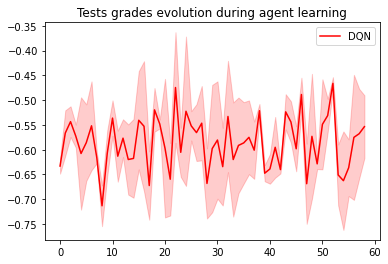


###################

      SEED 3

###################

 > Training DQN

Episode 0, episode return 0.0, last 20 avg 0.0
Episode 1, episode return 0.0, last 20 avg 0.0
Episode 2, episode return 0.0, last 20 avg 0.0
Episode 3, episode return 0.0, last 20 avg 0.0
Episode 4, episode return 0.0, last 20 avg 0.0
Episode 5, episode return 0.0, last 20 avg 0.0
Episode 6, episode return 0.0, last 20 avg 0.0
Episode 7, episode return 0.0, last 20 avg 0.0
Episode 8, episode return 0.0, last 20 avg 0.0
Episode 9, episode return 0.0, last 20 avg 0.0
Episode 10, episode return 0.0, last 20 avg 0.0
Episode 11, episode return 0.0, last 20 avg 0.0
Episode 12, episode return 0.0, last 20 avg 0.0
Episode 13, episode return 0.0, last 20 avg 0.0
Episode 14, episode return 0.0, last 20 avg 0.0
Episode 15, episode return 0.0, last 20 avg 0.0
Episode 16, episode return 0.0, last 20 avg 0.0
Episode 17, episode return 0.0, last 20 avg 0.0
Episode 18, episode return 0.0, last 20 avg 0.0
Episode 19, episode retu

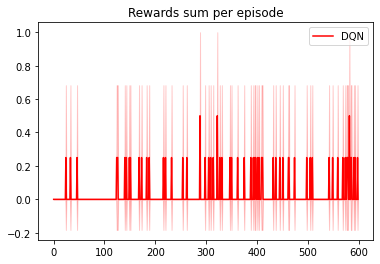

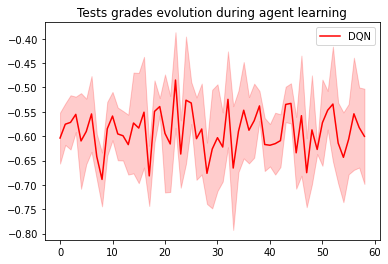

In [55]:
import matplotlib.pyplot as plt


environment = gym.make("goal_conditioned_discrete_grid_world-v0")
# We modified the map id to select the second map, the rest of the code is the same than above
environment.__init__(map_id=2)
environment.render()

nb_seeds = 4
nb_episodes_per_simulations = 600

dqn_seeds_rewards_result = []
dqn_seeds_tests_result = []
colors = ["#ff0000", "#ff9500"]

for seed_id in range(nb_seeds):
    print()
    print("###################")
    print()
    print("      SEED " + str(seed_id))
    print()
    print("###################")

    print()
    print(" > Training DQN")
    print()
    dqn_agent = GCDQNAgent(environment.observation_space, environment.action_space)
    rewards_sum_per_episode, tests_results = simulation(environment, dqn_agent,
                                                        nb_episodes=nb_episodes_per_simulations)
    dqn_seeds_rewards_result.append(rewards_sum_per_episode)
    dqn_seeds_tests_result.append(tests_results)

    plt.cla()
    plt.title("Rewards sum per episode")
    dqn_means = np.mean(np.array(dqn_seeds_rewards_result), axis=0)
    dqn_stds = np.std(np.array(dqn_seeds_rewards_result), axis=0)
    plt.plot(dqn_means, color=colors[0], label="DQN")
    plt.fill_between([x for x in range(len(dqn_means))], dqn_means + dqn_stds, dqn_means - dqn_stds, color=colors[0],
                     alpha=0.2)
    plt.legend()
    plt.show()

    plt.cla()
    plt.title("Tests grades evolution during agent learning")
    dqn_means = np.mean(np.array(dqn_seeds_tests_result), axis=0)
    dqn_stds = np.std(np.array(dqn_seeds_tests_result), axis=0)
    plt.plot(dqn_means, color=colors[0], label="DQN")
    plt.fill_between([x for x in range(len(dqn_means))], dqn_means + dqn_stds, dqn_means - dqn_stds, color=colors[0],
                     alpha=0.2)
    plt.legend()
    plt.show()

<div class="alert alert-warning">
Why our agent is not able to learn this time? (The expected answer is a bit more complex than just "the environment is harder" ;)
<div/>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>
    The agent cannot learn because finding a reaward is too complex in this environment.
    
With DQN, the model need to have rewards to converge and estimate the Q value of a state-action pair. While our agent don't find any rewards, the executed policy is equivalent to a pseudo-random one.
    
In the first map, the rewards was rich (goals close to the agent) but in the second one, they weren't. First, the size of the environment make goals far in average from the starting point of the agent. More, walls make the agent needs to go through threshold (which is still a state of the art challenge in reinforcement learning, but not a major one) to explore others rooms and find some rewards.
    
We can also see that some rewards are not enough to learn how to find new_ones. These rewarded samples are drowned into a larger amount of non-interesting samples inside the buffer.

<details/>

## Sparse reward problem
<div id="sparse"></div>

### Problem statement
<div id="sparse"></div>
Doing the last exercise, you just highlight the sparse reward problem. It occurs when the agent do not manage to find rewards. A way to prevent this, is to find a way to reuse the non-rewarded samples. We just saw that the few rewards found are drowned into a way larger amount of non-rewarded interactions. With Hindsight Experience replay, we will find a way to reuse them.

### Hindsight Experience Replay (HER) 

*(Exemple from the main paper of [HER](https://arxiv.org/pdf/1707.01495.pdf)*

Imagine a robot that tried to score a goal in soccer. After he shoot the ball, he will receive a rewardof 1 when a goal is scored, and a reward of 0 otherwise. If a reinforcement learning agent train on this task, and shoot 1000 times outside of the goal, he will not learn at all, and will still follow a pseudo-random policy. But if a human do the same, they will still learn from failed trials, and reuse what they learned to reach goal (or score goal in this example).

The idea of HER is to associate a reward for every non-rewarded samples, by a relabelling using a new goal in the same trajectory. Taken a failed trajectory, and an interaction (s, a, r=0, s', d=False, g) in this trajectory, this sambles can be associated with a reward using the last state of the trajectory 

    (s, a, r=R(s', st), s', d=(s' == st), g=st)

Where st is the last state in the trajectory, and R(s', st) a custom and intrinsic reward function (no more details in the paper about R, but I will give you a way to implement it).

Here is the HER algorithm:
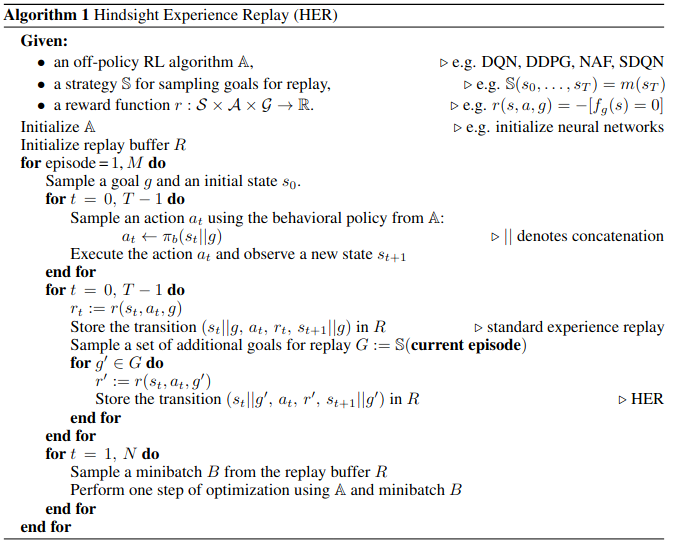

The part we're interested in is the second for loop of an episode (everything else is reinforcement learning as we saw in previous notebook). There, we can see that for each steps, they sample a set of goals. They propose many way to select them, but according to their experiments, the way that have the best performances is to select 5 subgoals for each sample, with each new goals being between s and st in the trajectory.


<div class="alert alert-warning">
To make sure you understood well, if we have a trajectory of length 10 (10 samples (s, a, r, s', d, g)). How many samples in total will be stored in the buffer using HER with the goal selection strategy described above ?
<div/>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>
    
First, each of these sample will be stored in the buffer (step "standard experience replay" of the algorithm above). Then, we will store 5 relabelled samples for each samples. In total, we will store 60 samples from a trajectory of size 10.
<details/>

<div class="alert alert-warning">
In an goal reaching task where the agent recieve a reward of 1 when he reach the goal, and a reward of 0 when he don't. What can be a good function for R(s, g) ?
    
NB: you can use any informations in your possetion at the moment you relabel samples
<div/>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>
We can use samples index in the trajectory. After sampling a goal with index $g_i$, for a state with index $s_i$ in the trajectory, we know that the state s it the step $s_i$ in a trajectory that reach $g$ in $g_i$ steps.
    
Because we did $s_i / s_g * 100$ percent of the travel at this step, and because the reward goes from 0 to 1, we can compute this reward as $R(s, s_i, g, g_i) = s_i / s_g$
<details/>

Now you understood HER, implement it below (note that the code heritate from GCDQNAgent).

In [15]:
import copy
import random
from random import randrange

import gym
import numpy as np
import torch
from torch import nn, optim
from torch.nn import ReLU


class HERAgent(GCDQNAgent):
    """
    An agent that learn an approximated Q-Function using a neural network.
    This Q-Function is used to find the best action to execute in a given state.
    """

    def __init__(self, state_space, action_space, goal_size=None, name="DQN + HER",
                 gamma=0.95, epsilon_min=0.01, epsilon_max=1., epsilon_decay_period=1000, epsilon_decay_delay=20,
                 buffer_size=1000000, learning_rate=0.001, update_target_freq=100, batch_size=125,
                 layer_1_size=250, layer_2_size=200, nb_gradient_steps=1):

        super().__init__(state_space, action_space, goal_size=goal_size, name=name, gamma=gamma, 
                         epsilon_min=epsilon_min, epsilon_max=epsilon_max, 
                         epsilon_decay_period=epsilon_decay_period, epsilon_decay_delay=epsilon_decay_delay, 
                         buffer_size=buffer_size, learning_rate=learning_rate,
                         update_target_freq=update_target_freq, batch_size=batch_size, layer_1_size=layer_1_size,
                         layer_2_size=layer_2_size, nb_gradient_steps=nb_gradient_steps)

    def action(self, state):
        return super().action(state)

    def on_episode_start(self, episode_info, episode_id):
        res = super().on_episode_start(episode_info, episode_id)
        return res

    def on_action_stop(self, action, new_state, reward, done):
        self.last_trajectory.append((self.last_state, action))

        return super().on_action_stop(action, new_state, reward, done)

    def on_episode_stop(self):
        # Relabel last trajectory
        # TODO (For this todo, you will need to add some stuff in the functions above)

SyntaxError: unexpected EOF while parsing (1528024556.py, line 44)

In [17]:
# %load solutions/RL7/her.py
import copy
import random
from random import randrange

import gym
import numpy as np
import torch
from torch import nn, optim
from torch.nn import ReLU


class HERAgent(GCDQNAgent):
    """
    An agent that learn an approximated Q-Function using a neural network.
    This Q-Function is used to find the best action to execute in a given state.
    """

    def __init__(self, state_space, action_space, goal_size=None, name="DQN + HER",
                 gamma=0.95, epsilon_min=0.01, epsilon_max=1., epsilon_decay_period=1000, epsilon_decay_delay=20,
                 buffer_size=1000000, learning_rate=0.001, update_target_freq=100, batch_size=125,
                 layer_1_size=250, layer_2_size=200, nb_gradient_steps=1):

        super().__init__(state_space, action_space, goal_size=goal_size, name=name, gamma=gamma, 
                         epsilon_min=epsilon_min, epsilon_max=epsilon_max, 
                         epsilon_decay_period=epsilon_decay_period, epsilon_decay_delay=epsilon_decay_delay, 
                         buffer_size=buffer_size, learning_rate=learning_rate,
                         update_target_freq=update_target_freq, batch_size=batch_size, layer_1_size=layer_1_size,
                         layer_2_size=layer_2_size, nb_gradient_steps=nb_gradient_steps)

        # HER will relabel samples in the last trajectory. To do it, we need to keep this last trajectory in a memory
        self.last_trajectory = []
        # ... and store relabelling parameters
        self.nb_resample_per_states = 5

    def action(self, state):
        return super().action(state)

    def on_episode_start(self, episode_info, episode_id):
        res = super().on_episode_start(episode_info, episode_id)
        self.last_trajectory = []
        return res

    def on_action_stop(self, action, new_state, reward, done):
        self.last_trajectory.append((self.last_state, action))

        return super().on_action_stop(action, new_state, reward, done)

    def on_episode_stop(self):
        # Relabel last trajectory
        if len(self.last_trajectory) <= self.nb_resample_per_states:
            return
        # For each state seen (so each sample):
        for state_index, (state, action) in enumerate(self.last_trajectory[:-4]):
            new_state_index = state_index + 1
            new_state, _ = self.last_trajectory[new_state_index]

            # sample four goals in future states
            for relabelling_id in range(self.nb_resample_per_states):
                goal_index = randrange(new_state_index, len(self.last_trajectory))
                goal, _ = self.last_trajectory[goal_index]
                reward = new_state_index / goal_index
                self.replay_buffer.append(state, action, reward, new_state, goal_index == new_state_index, goal[-2:])


Now you implemented it, you can compate it to DQN in the simple map using the code below:

/home/ubuntu/anaconda3/envs/pie-rl/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


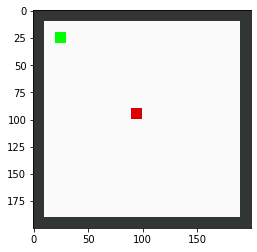


###################

      SEED 0

###################

 > Training DQN + HER

Episode 0, episode return 0.0, last 20 avg 0.0
Episode 1, episode return 1.0, last 20 avg 0.5
Episode 2, episode return 0.0, last 20 avg 0.3333333333333333
Episode 3, episode return 0.0, last 20 avg 0.25
Episode 4, episode return 0.0, last 20 avg 0.2
Episode 5, episode return 0.0, last 20 avg 0.16666666666666666
Episode 6, episode return 0.0, last 20 avg 0.14285714285714285
Episode 7, episode return 0.0, last 20 avg 0.125
Episode 8, episode return 1.0, last 20 avg 0.2222222222222222
Episode 9, episode return 1.0, last 20 avg 0.3
Episode 10, episode return 1.0, last 20 avg 0.36363636363636365
Episode 11, episode return 0.0, last 20 avg 0.3333333333333333
Episode 12, episode return 0.0, last 20 avg 0.3076923076923077
Episode 13, episode return 0.0, last 20 avg 0.2857142857142857
Episode 14, episode return 0.0, last 20 avg 0.26666666666666666
Episode 15, episode return 1.0, last 20 avg 0.3125
Episode 16, episo

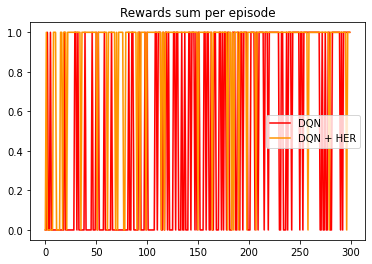

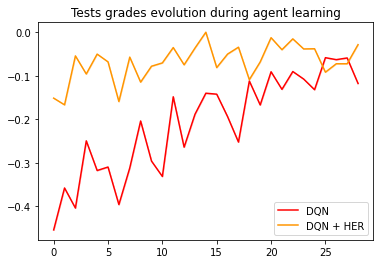


###################

      SEED 1

###################

 > Training DQN + HER

Episode 0, episode return 0.0, last 20 avg 0.0
Episode 1, episode return 0.0, last 20 avg 0.0
Episode 2, episode return 0.0, last 20 avg 0.0
Episode 3, episode return 0.0, last 20 avg 0.0
Episode 4, episode return 0.0, last 20 avg 0.0
Episode 5, episode return 0.0, last 20 avg 0.0
Episode 6, episode return 0.0, last 20 avg 0.0
Episode 7, episode return 0.0, last 20 avg 0.0
Episode 8, episode return 1.0, last 20 avg 0.1111111111111111
Episode 9, episode return 0.0, last 20 avg 0.1
Episode 10, episode return 0.0, last 20 avg 0.09090909090909091
Episode 11, episode return 1.0, last 20 avg 0.16666666666666666
Episode 12, episode return 1.0, last 20 avg 0.23076923076923078
Episode 13, episode return 1.0, last 20 avg 0.2857142857142857
Episode 14, episode return 1.0, last 20 avg 0.3333333333333333
Episode 15, episode return 1.0, last 20 avg 0.375
Episode 16, episode return 1.0, last 20 avg 0.4117647058823529
Epis

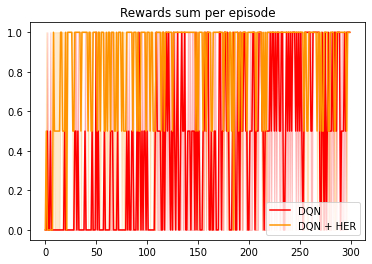

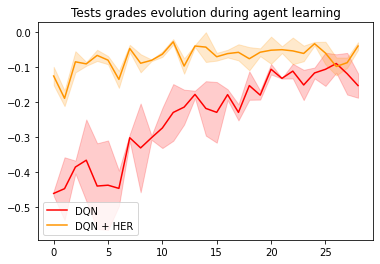


###################

      SEED 2

###################

 > Training DQN + HER

Episode 0, episode return 0.0, last 20 avg 0.0
Episode 1, episode return 0.0, last 20 avg 0.0
Episode 2, episode return 0.0, last 20 avg 0.0
Episode 3, episode return 0.0, last 20 avg 0.0
Episode 4, episode return 0.0, last 20 avg 0.0
Episode 5, episode return 0.0, last 20 avg 0.0
Episode 6, episode return 1.0, last 20 avg 0.14285714285714285
Episode 7, episode return 1.0, last 20 avg 0.25
Episode 8, episode return 0.0, last 20 avg 0.2222222222222222
Episode 9, episode return 0.0, last 20 avg 0.2
Episode 10, episode return 0.0, last 20 avg 0.18181818181818182
Episode 11, episode return 1.0, last 20 avg 0.25
Episode 12, episode return 1.0, last 20 avg 0.3076923076923077
Episode 13, episode return 1.0, last 20 avg 0.35714285714285715
Episode 14, episode return 0.0, last 20 avg 0.3333333333333333
Episode 15, episode return 1.0, last 20 avg 0.375
Episode 16, episode return 1.0, last 20 avg 0.4117647058823529
Ep

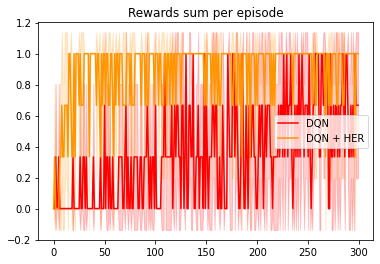

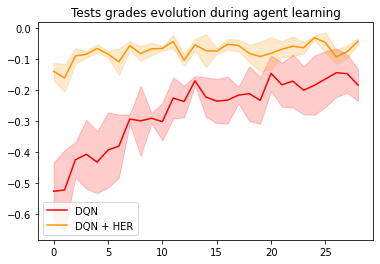


###################

      SEED 3

###################

 > Training DQN + HER

Episode 0, episode return 0.0, last 20 avg 0.0
Episode 1, episode return 0.0, last 20 avg 0.0
Episode 2, episode return 0.0, last 20 avg 0.0
Episode 3, episode return 0.0, last 20 avg 0.0
Episode 4, episode return 0.0, last 20 avg 0.0
Episode 5, episode return 1.0, last 20 avg 0.16666666666666666
Episode 6, episode return 0.0, last 20 avg 0.14285714285714285
Episode 7, episode return 1.0, last 20 avg 0.25
Episode 8, episode return 0.0, last 20 avg 0.2222222222222222
Episode 9, episode return 0.0, last 20 avg 0.2
Episode 10, episode return 0.0, last 20 avg 0.18181818181818182
Episode 11, episode return 0.0, last 20 avg 0.16666666666666666
Episode 12, episode return 0.0, last 20 avg 0.15384615384615385
Episode 13, episode return 0.0, last 20 avg 0.14285714285714285
Episode 14, episode return 1.0, last 20 avg 0.2
Episode 15, episode return 1.0, last 20 avg 0.25
Episode 16, episode return 0.0, last 20 avg 0.235

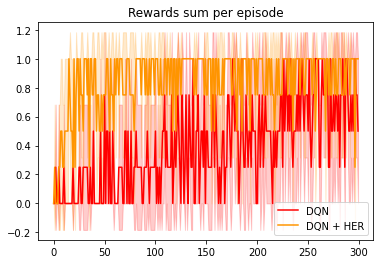

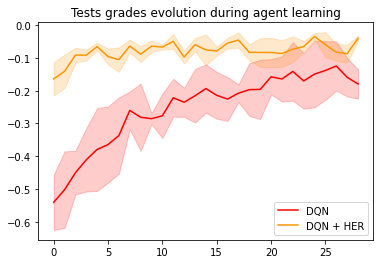

In [18]:
# Compare HER to DQN in simple env
environment = gym.make("goal_conditioned_discrete_grid_world-v0")
environment.__init__(map_id=1)
environment.render()
nb_seeds = 4
nb_episodes_per_simulations = 300
dqn_seeds_rewards_result = []
dqn_seeds_tests_result = []
her_seeds_rewards_result = []
her_seeds_tests_result = []
colors = ["#ff0000", "#ff9500"]
for seed_id in range(nb_seeds):
    print()
    print("###################")
    print()
    print("      SEED " + str(seed_id))
    print()
    print("###################")

    print()
    print(" > Training DQN + HER")
    print()
    her_agent = HERAgent(environment.observation_space, environment.action_space)
    rewards_sum_per_episode, tests_results = simulation(environment, her_agent,
                                                        nb_episodes=nb_episodes_per_simulations)
    her_seeds_rewards_result.append(rewards_sum_per_episode)
    her_seeds_tests_result.append(tests_results)

    print()
    print(" > Training DQN")
    print()
    dqn_agent = GCDQNAgent(environment.observation_space, environment.action_space)
    rewards_sum_per_episode, tests_results = simulation(environment, dqn_agent,
                                                        nb_episodes=nb_episodes_per_simulations)
    dqn_seeds_rewards_result.append(rewards_sum_per_episode)
    dqn_seeds_tests_result.append(tests_results)

    plt.cla()
    plt.title("Rewards sum per episode")
    dqn_means = np.mean(np.array(dqn_seeds_rewards_result), axis=0)
    dqn_stds = np.std(np.array(dqn_seeds_rewards_result), axis=0)
    plt.plot(dqn_means, color=colors[0], label="DQN")
    plt.fill_between([x for x in range(len(dqn_means))], dqn_means + dqn_stds, dqn_means - dqn_stds, color=colors[0],
                     alpha=0.2)
    her_means = np.mean(np.array(her_seeds_rewards_result), axis=0)
    her_stds = np.std(np.array(her_seeds_rewards_result), axis=0)
    plt.plot(her_means, color=colors[1], label="DQN + HER")
    plt.fill_between([x for x in range(len(her_means))], her_means + her_stds, her_means - her_stds, color=colors[1],
                     alpha=0.2)
    plt.legend()
    plt.show()

    plt.cla()
    plt.title("Tests grades evolution during agent learning")
    dqn_means = np.mean(np.array(dqn_seeds_tests_result), axis=0)
    dqn_stds = np.std(np.array(dqn_seeds_tests_result), axis=0)
    plt.plot(dqn_means, color=colors[0], label="DQN")
    plt.fill_between([x for x in range(len(dqn_means))], dqn_means + dqn_stds, dqn_means - dqn_stds, color=colors[0],
                     alpha=0.2)
    her_means = np.mean(np.array(her_seeds_tests_result), axis=0)
    her_stds = np.std(np.array(her_seeds_tests_result), axis=0)
    plt.plot(her_means, color=colors[1], label="DQN + HER")
    plt.fill_between([x for x in range(len(her_means))], her_means + her_stds, her_means - her_stds, color=colors[1],
                     alpha=0.2)
    plt.legend()
    plt.show()

Now, observe it's performances inside the harder 4 rooms map:

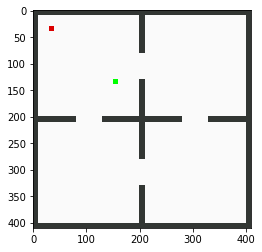


###################

      SEED 0

###################

 > Training HERAgent

Episode 0, episode return 0.0, last 20 avg 0.0
Episode 1, episode return 0.0, last 20 avg 0.0
Episode 2, episode return 0.0, last 20 avg 0.0
Episode 3, episode return 0.0, last 20 avg 0.0
Episode 4, episode return 0.0, last 20 avg 0.0
Episode 5, episode return 0.0, last 20 avg 0.0
Episode 6, episode return 0.0, last 20 avg 0.0
Episode 7, episode return 0.0, last 20 avg 0.0
Episode 8, episode return 0.0, last 20 avg 0.0
Episode 9, episode return 1.0, last 20 avg 0.1
Episode 10, episode return 0.0, last 20 avg 0.09090909090909091
Episode 11, episode return 0.0, last 20 avg 0.08333333333333333
Episode 12, episode return 0.0, last 20 avg 0.07692307692307693
Episode 13, episode return 0.0, last 20 avg 0.07142857142857142
Episode 14, episode return 0.0, last 20 avg 0.06666666666666667
Episode 15, episode return 0.0, last 20 avg 0.0625
Episode 16, episode return 0.0, last 20 avg 0.058823529411764705
Episode 17, epi

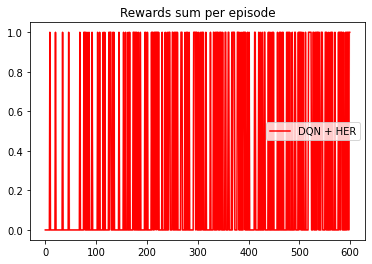

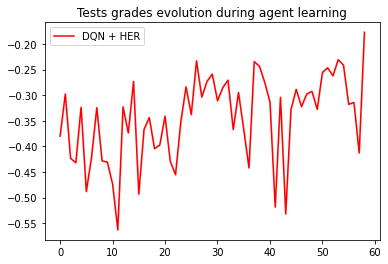


###################

      SEED 1

###################

 > Training HERAgent

Episode 0, episode return 0.0, last 20 avg 0.0
Episode 1, episode return 0.0, last 20 avg 0.0
Episode 2, episode return 0.0, last 20 avg 0.0
Episode 3, episode return 0.0, last 20 avg 0.0
Episode 4, episode return 0.0, last 20 avg 0.0
Episode 5, episode return 0.0, last 20 avg 0.0
Episode 6, episode return 1.0, last 20 avg 0.14285714285714285
Episode 7, episode return 0.0, last 20 avg 0.125
Episode 8, episode return 0.0, last 20 avg 0.1111111111111111
Episode 9, episode return 0.0, last 20 avg 0.1
Episode 10, episode return 0.0, last 20 avg 0.09090909090909091
Episode 11, episode return 0.0, last 20 avg 0.08333333333333333
Episode 12, episode return 0.0, last 20 avg 0.07692307692307693
Episode 13, episode return 0.0, last 20 avg 0.07142857142857142
Episode 14, episode return 0.0, last 20 avg 0.06666666666666667
Episode 15, episode return 0.0, last 20 avg 0.0625
Episode 16, episode return 0.0, last 20 avg 0.0

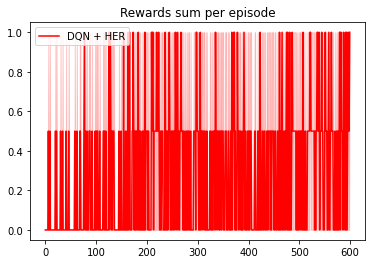

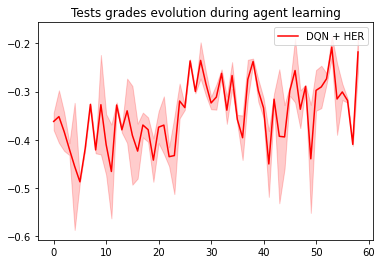


###################

      SEED 2

###################

 > Training HERAgent

Episode 0, episode return 0.0, last 20 avg 0.0
Episode 1, episode return 0.0, last 20 avg 0.0
Episode 2, episode return 0.0, last 20 avg 0.0
Episode 3, episode return 0.0, last 20 avg 0.0
Episode 4, episode return 0.0, last 20 avg 0.0
Episode 5, episode return 0.0, last 20 avg 0.0
Episode 6, episode return 0.0, last 20 avg 0.0
Episode 7, episode return 1.0, last 20 avg 0.125
Episode 8, episode return 0.0, last 20 avg 0.1111111111111111
Episode 9, episode return 1.0, last 20 avg 0.2
Episode 10, episode return 0.0, last 20 avg 0.18181818181818182
Episode 11, episode return 0.0, last 20 avg 0.16666666666666666
Episode 12, episode return 0.0, last 20 avg 0.15384615384615385
Episode 13, episode return 0.0, last 20 avg 0.14285714285714285
Episode 14, episode return 1.0, last 20 avg 0.2
Episode 15, episode return 1.0, last 20 avg 0.25
Episode 16, episode return 0.0, last 20 avg 0.23529411764705882
Episode 17, episo

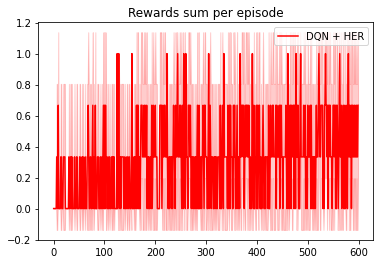

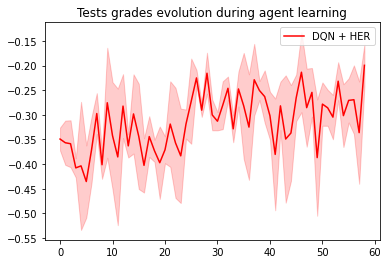


###################

      SEED 3

###################

 > Training HERAgent

Episode 0, episode return 0.0, last 20 avg 0.0
Episode 1, episode return 0.0, last 20 avg 0.0
Episode 2, episode return 0.0, last 20 avg 0.0
Episode 3, episode return 0.0, last 20 avg 0.0
Episode 4, episode return 0.0, last 20 avg 0.0
Episode 5, episode return 0.0, last 20 avg 0.0
Episode 6, episode return 0.0, last 20 avg 0.0
Episode 7, episode return 0.0, last 20 avg 0.0
Episode 8, episode return 1.0, last 20 avg 0.1111111111111111
Episode 9, episode return 0.0, last 20 avg 0.1
Episode 10, episode return 0.0, last 20 avg 0.09090909090909091
Episode 11, episode return 0.0, last 20 avg 0.08333333333333333
Episode 12, episode return 0.0, last 20 avg 0.07692307692307693
Episode 13, episode return 0.0, last 20 avg 0.07142857142857142
Episode 14, episode return 0.0, last 20 avg 0.06666666666666667
Episode 15, episode return 0.0, last 20 avg 0.0625
Episode 16, episode return 0.0, last 20 avg 0.058823529411764705


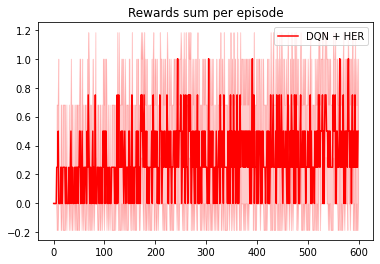

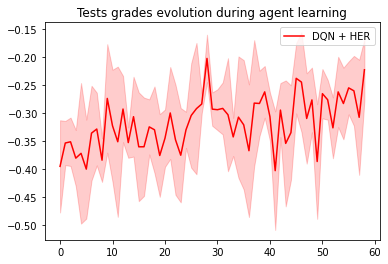

In [70]:
import matplotlib.pyplot as plt


environment = gym.make("goal_conditioned_discrete_grid_world-v0")
# We modified the map id to select the second map, the rest of the code is the same than above
environment.__init__(map_id=2)
environment.render()

nb_seeds = 4
nb_episodes_per_simulations = 600

her_seeds_rewards_result = []
her_seeds_tests_result = []
colors = ["#ff0000", "#ff9500"]

for seed_id in range(nb_seeds):
    print()
    print("###################")
    print()
    print("      SEED " + str(seed_id))
    print()
    print("###################")

    print()
    print(" > Training HERAgent")
    print()
    her_agent = HERAgent(environment.observation_space, environment.action_space)
    rewards_sum_per_episode, tests_results = simulation(environment, her_agent,
                                                        nb_episodes=nb_episodes_per_simulations)
    her_seeds_rewards_result.append(rewards_sum_per_episode)
    her_seeds_tests_result.append(tests_results)

    plt.cla()
    plt.title("Rewards sum per episode")
    her_means = np.mean(np.array(her_seeds_rewards_result), axis=0)
    her_stds = np.std(np.array(her_seeds_rewards_result), axis=0)
    plt.plot(her_means, color=colors[0], label="DQN + HER")
    plt.fill_between([x for x in range(len(her_means))], her_means + her_stds, her_means - her_stds, color=colors[0],
                     alpha=0.2)
    plt.legend()
    plt.show()

    plt.cla()
    plt.title("Tests grades evolution during agent learning")
    her_means = np.mean(np.array(her_seeds_tests_result), axis=0)
    her_stds = np.std(np.array(her_seeds_tests_result), axis=0)
    plt.plot(her_means, color=colors[0], label="DQN + HER")
    plt.fill_between([x for x in range(len(her_means))], her_means + her_stds, her_means - her_stds, color=colors[0],
                     alpha=0.2)
    plt.legend()
    plt.show()

We saw that our agent learn, but is not able to reach every environments. We will se why with the next environment.

## Swing up

Now we will try to use HER to beat swing up (the custom cart-pole environment you tried to beat on RL5 without success). But Swing up is not a goal-conditionned environment!

<div class="alert alert-warning">
How can we adapt our swing up environment to make it generate goals that help the agent to beat the environment?
<div/>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>
        
We can simply generate angles between -pi and pi and angle dot so it can be used as goals to reach.
<details/>

<div class="alert alert-warning">
How can test the ability of a goal reaching agent to beat the environment? (remember that we need to give him a goal to make it run)
<div/>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>
We know the coordinate of the Swing Up reward (angle = 0, angle dot = 0), we just need to generate this goal and see if our agent can reach it.
<details/>

I created a custom environment GoalSwingUp, that do the trick for you. It generage goal on reset(), and the test function coded above ask the environment to generate a specifig goal for test. Now, test the HER agent on GoalSwingUp:

In [19]:
def demonstration(agent, environment):
    agent.on_simulation_start()
    if isinstance(environment, GoalCartPoleSwingUp):
        state, goal = environment.reset(test=True)
    else:
        state, goal = environment.reset()
    agent.on_episode_start(state, goal)
    environment.render()
    image = environment.render()
    
    done = False
    while not done:
        action = agent.action(state)
        state, _, done, _ = environment.step(action)
        environment.render()
    

/home/ubuntu/anaconda3/envs/pie-rl/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/ubuntu/anaconda3/envs/pie-rl/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))



###################

      SEED 0

###################

 > Training HERAgent

Episode 0, episode return 2.0, last 20 avg 2.0
Episode 1, episode return -3.0, last 20 avg -0.5
Episode 2, episode return -7.0, last 20 avg -2.6666666666666665
Episode 3, episode return 0.0, last 20 avg -2.0
Episode 4, episode return -6.0, last 20 avg -2.8
Episode 5, episode return 4.0, last 20 avg -1.6666666666666667


/tmp/ipykernel_8522/3548704813.py:20: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return list(map(lambda x:torch.Tensor(x).to(self.device), list(zip(*batch))))


Episode 6, episode return 2.0, last 20 avg -1.1428571428571428
Episode 7, episode return -3.0, last 20 avg -1.375
Episode 8, episode return -6.0, last 20 avg -1.8888888888888888
Episode 9, episode return 5.0, last 20 avg -1.2
Episode 10, episode return -3.0, last 20 avg -1.3636363636363635
Episode 11, episode return -7.0, last 20 avg -1.8333333333333333
Episode 12, episode return -7.0, last 20 avg -2.230769230769231
Episode 13, episode return -9.0, last 20 avg -2.7142857142857144
Episode 14, episode return -10.0, last 20 avg -3.2
Episode 15, episode return -8.0, last 20 avg -3.5
Episode 16, episode return -10.0, last 20 avg -3.8823529411764706
Episode 17, episode return -7.0, last 20 avg -4.055555555555555
Episode 18, episode return -10.0, last 20 avg -4.368421052631579
Episode 19, episode return -6.0, last 20 avg -4.45
Episode 20, episode return 0.0, last 20 avg -4.55
Episode 21, episode return -8.0, last 20 avg -4.8
Episode 22, episode return -10.0, last 20 avg -4.95
Episode 23, epis

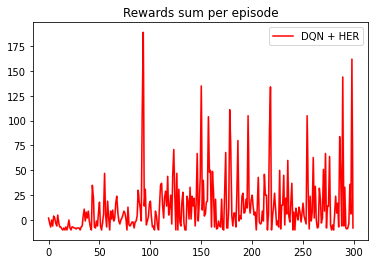

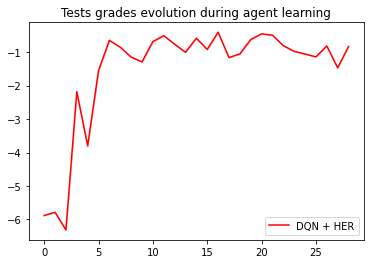


###################

      SEED 1

###################

 > Training HERAgent

Episode 0, episode return -7.0, last 20 avg -7.0
Episode 1, episode return -8.0, last 20 avg -7.5


/tmp/ipykernel_8522/3548704813.py:20: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return list(map(lambda x:torch.Tensor(x).to(self.device), list(zip(*batch))))


Episode 2, episode return -6.0, last 20 avg -7.0
Episode 3, episode return -6.0, last 20 avg -6.75
Episode 4, episode return -1.0, last 20 avg -5.6
Episode 5, episode return -5.0, last 20 avg -5.5
Episode 6, episode return -5.0, last 20 avg -5.428571428571429
Episode 7, episode return 2.0, last 20 avg -4.5
Episode 8, episode return -8.0, last 20 avg -4.888888888888889
Episode 9, episode return -1.0, last 20 avg -4.5
Episode 10, episode return -10.0, last 20 avg -5.0
Episode 11, episode return -7.0, last 20 avg -5.166666666666667
Episode 12, episode return -1.0, last 20 avg -4.846153846153846
Episode 13, episode return -8.0, last 20 avg -5.071428571428571
Episode 14, episode return -7.0, last 20 avg -5.2
Episode 15, episode return -7.0, last 20 avg -5.3125
Episode 16, episode return -7.0, last 20 avg -5.411764705882353
Episode 17, episode return -9.0, last 20 avg -5.611111111111111
Episode 18, episode return 0.0, last 20 avg -5.315789473684211
Episode 19, episode return -4.0, last 20 av

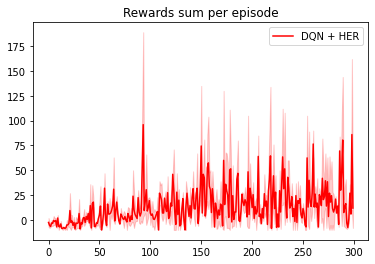

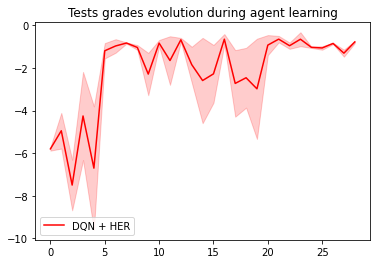


###################

      SEED 2

###################

 > Training HERAgent

Episode 0, episode return 7.0, last 20 avg 7.0
Episode 1, episode return -8.0, last 20 avg -0.5
Episode 2, episode return -2.0, last 20 avg -1.0
Episode 3, episode return -7.0, last 20 avg -2.5
Episode 4, episode return -6.0, last 20 avg -3.2
Episode 5, episode return -10.0, last 20 avg -4.333333333333333
Episode 6, episode return -7.0, last 20 avg -4.714285714285714
Episode 7, episode return -2.0, last 20 avg -4.375
Episode 8, episode return -4.0, last 20 avg -4.333333333333333
Episode 9, episode return -4.0, last 20 avg -4.3
Episode 10, episode return -6.0, last 20 avg -4.454545454545454


/tmp/ipykernel_8522/3548704813.py:20: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return list(map(lambda x:torch.Tensor(x).to(self.device), list(zip(*batch))))


Episode 11, episode return -10.0, last 20 avg -4.916666666666667
Episode 12, episode return -10.0, last 20 avg -5.3076923076923075
Episode 13, episode return -4.0, last 20 avg -5.214285714285714
Episode 14, episode return -10.0, last 20 avg -5.533333333333333
Episode 15, episode return -7.0, last 20 avg -5.625
Episode 16, episode return -7.0, last 20 avg -5.705882352941177
Episode 17, episode return -9.0, last 20 avg -5.888888888888889
Episode 18, episode return -7.0, last 20 avg -5.947368421052632
Episode 19, episode return -4.0, last 20 avg -5.85
Episode 20, episode return -5.0, last 20 avg -6.45
Episode 21, episode return -5.0, last 20 avg -6.3
Episode 22, episode return -4.0, last 20 avg -6.4
Episode 23, episode return 2.0, last 20 avg -5.95
Episode 24, episode return -10.0, last 20 avg -6.15
Episode 25, episode return -1.0, last 20 avg -5.7
Episode 26, episode return -7.0, last 20 avg -5.7
Episode 27, episode return -10.0, last 20 avg -6.1
Episode 28, episode return -8.0, last 20 

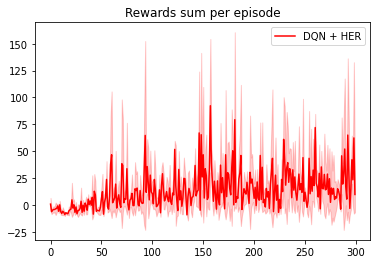

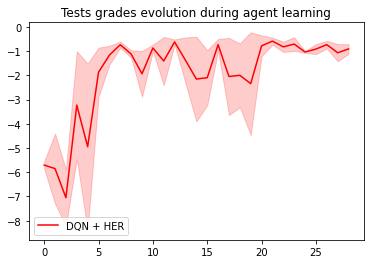


###################

      SEED 3

###################

 > Training HERAgent

Episode 0, episode return -6.0, last 20 avg -6.0
Episode 1, episode return -7.0, last 20 avg -6.5
Episode 2, episode return 26.0, last 20 avg 4.333333333333333
Episode 3, episode return -10.0, last 20 avg 0.75
Episode 4, episode return -3.0, last 20 avg 0.0
Episode 5, episode return -7.0, last 20 avg -1.1666666666666667


/tmp/ipykernel_8522/3548704813.py:20: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return list(map(lambda x:torch.Tensor(x).to(self.device), list(zip(*batch))))


Episode 6, episode return -6.0, last 20 avg -1.8571428571428572
Episode 7, episode return -8.0, last 20 avg -2.625
Episode 8, episode return -2.0, last 20 avg -2.5555555555555554
Episode 9, episode return -7.0, last 20 avg -3.0
Episode 10, episode return -10.0, last 20 avg -3.6363636363636362
Episode 11, episode return -6.0, last 20 avg -3.8333333333333335
Episode 12, episode return -8.0, last 20 avg -4.153846153846154
Episode 13, episode return -6.0, last 20 avg -4.285714285714286
Episode 14, episode return -10.0, last 20 avg -4.666666666666667
Episode 15, episode return -5.0, last 20 avg -4.6875
Episode 16, episode return -7.0, last 20 avg -4.823529411764706
Episode 17, episode return 28.0, last 20 avg -3.0
Episode 18, episode return 34.0, last 20 avg -1.0526315789473684
Episode 19, episode return -5.0, last 20 avg -1.25
Episode 20, episode return -3.0, last 20 avg -1.1
Episode 21, episode return -7.0, last 20 avg -1.1
Episode 22, episode return -5.0, last 20 avg -2.65
Episode 23, ep

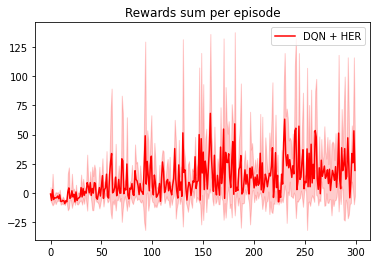

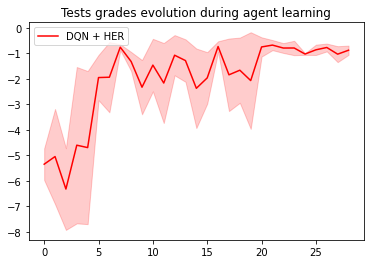

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from environments.swingup import GoalCartPoleSwingUp

environment = GoalCartPoleSwingUp()

nb_seeds = 4
nb_episodes_per_simulations = 300

her_seeds_rewards_result = []
her_seeds_tests_result = []
colors = ["#ff0000", "#ff9500"]

for seed_id in range(nb_seeds):
    print()
    print("###################")
    print()
    print("      SEED " + str(seed_id))
    print()
    print("###################")

    print()
    print(" > Training HERAgent")
    print()
    her_agent = HERAgent(environment.observation_space, environment.action_space, goal_size=2)
    rewards_sum_per_episode, tests_results = simulation(environment, her_agent,
                                                        nb_episodes=nb_episodes_per_simulations)
    her_seeds_rewards_result.append(rewards_sum_per_episode)
    her_seeds_tests_result.append(tests_results)

    plt.cla()
    plt.title("Rewards sum per episode")
    her_means = np.mean(np.array(her_seeds_rewards_result), axis=0)
    her_stds = np.std(np.array(her_seeds_rewards_result), axis=0)
    plt.plot(her_means, color=colors[0], label="DQN + HER")
    plt.fill_between([x for x in range(len(her_means))], her_means + her_stds, her_means - her_stds, color=colors[0],
                     alpha=0.2)
    plt.legend()
    plt.show()

    plt.cla()
    plt.title("Tests grades evolution during agent learning")
    her_means = np.mean(np.array(her_seeds_tests_result), axis=0)
    her_stds = np.std(np.array(her_seeds_tests_result), axis=0)
    plt.plot(her_means, color=colors[0], label="DQN + HER")
    plt.fill_between([x for x in range(len(her_means))], her_means + her_stds, her_means - her_stds, color=colors[0],
                     alpha=0.2)
    
    demonstration(her_agent, environment)
    plt.legend()
    plt.show()

<div class="alert alert-warning">
What is it working a bit, but the agent don't reach perfectly the goal everytime ?
<div/>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>
We know the coordinate of the Swing Up reward (angle = 0, angle dot = 0), we just need to generate this goal and see if our agent can reach it.
<details/>

<div class="alert alert-warning">
How can we fix it?
<div/>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>
Our agent just need more training time to learn how to pass through state space bottlenecks, and a bit more stability. For exemple, a SoftDQN (an adaptation of soft Actor-Critic for discrete state spaces) should do the trick.
<details/>

## To go further

To help our agent to reach goals when the environment contains bottlenecks (mandatory states, where the agent should pass before to reach another sub-space of the environment state space), we can try to do planning, or to increase exploration.

In planning, we want our agent to learn a topology (kind of a graph of states clusters) of the environment, so he can use this topology to reach far away goals using path finding on the graph.

Many approches try to improve the exploration, using intrinsic rewards. For example, the agent can receive a reward when he find states that he didnt reach that much, or get a reward when he is not able to predict the next state, which mean that he never goes in this area of the state space.